# Bash Script coomand Classification

In [45]:
from more_itertools import chunked
from functional import seq
from pathlib import Path
import pandas as pd
import glob
import random
import numpy as np
from toolz import curry
from collections import Counter
import matplotlib.pyplot as plt

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)

In [3]:
SEED = 23
LABEL_PATH: Path = "./label_data.csv"
DATA_REGEX: str = "./FraudedRawData/User*"

In [4]:
random.seed(SEED)
np.random.seed(SEED)

## Utils

### Plot

In [48]:
def dict_to_bar_plot(data, title: str):
    """
    Takes a dictionary as input and creates a bar plot.
    
    Parameters:
    data (dict): A dictionary where keys are categories and values are numerical data.
    
    Returns:
    None
    """
    keys = list(data.keys())
    values = list(data.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Bash Command')
    plt.ylabel('Frequence')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Transforms

In [5]:
def split_into_segments(content: list[str], *, segment_size: int = 100):
    return list(chunked(content, segment_size))

In [6]:
def join_segments(content: list[list[str]]):
    return seq(content).map(lambda line: " ".join(line))

In [7]:
@curry
def binary_label_by_user(user_id: int, df: pd.DataFrame):
    cpy = df.copy()
    cpy["label"] = cpy["userId"].apply(lambda x: int(x != f"User{user_id}"))
    return cpy

In [8]:
@curry
def filter_by_user_id(user_id: int, df: pd.DataFrame) -> pd.DataFrame:
    return (df[df["userId"] == f"User{user_id}"]).copy()

In [9]:
def flatten_df(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    """organize as a simple table format"""
    df = df.reset_index()
    df = df.melt(id_vars="index", var_name="segment", value_name=value_name)
    df.rename(columns={"index": "userId"}, inplace=True)
    return df

### Loading

In [10]:
def get_file_conetent(file: Path):
    with open(file, "r") as f:
        return seq(f.readlines()).map(lambda line: line.strip()).to_list()

In [11]:
def load_label_df(path: Path) -> pd.DataFrame:
    label_df: pd.DataFrame = pd.read_csv(path)
    label_df.set_index("Unnamed: 0", inplace=True)
    label_df.index.name = None
    return label_df

In [12]:
def load_text_data(regex: str):
    files_paths: list[Path] = glob.glob(regex)
    files: list[list[str]] = (
        seq(files_paths)
        .map(get_file_conetent)
        .map(split_into_segments)
        .map(join_segments)
    )
    files = seq(files_paths).map(lambda s: s.split("/")[-1]).zip(files).to_dict()
    df: pd.DataFrame = pd.DataFrame.from_dict(files).transpose()
    new_column_names = {i: f"{i*100}-{(i+1)*100}" for i in df.columns}
    df.rename(columns=new_column_names, inplace=True)
    df.sort_index(inplace=True)
    return df

### Steps:

In [13]:
def train(df: pd.DataFrame, *, models: dict[int, Pipeline]) -> dict[int, Pipeline]:
    for user in models.keys():
        tmp_df = binary_label_by_user(user)(df)
        models[user].fit(tmp_df["text"], tmp_df["label"])
    return models

In [14]:
def test(df: pd.DataFrame, *, models: dict[int, Pipeline]) -> pd.DataFrame:
    results = defaultdict(list)
    for user in models.keys():
        tmp_df = binary_label_by_user(user)(df)
        y_pred = models[user].predict(tmp_df["text"])
        y_label = tmp_df["label"]
        results["preecision"].append(precision_score(y_label, y_pred, average="binary"))
        results["recall"].append(recall_score(y_label, y_pred, average="binary"))
        results["acc"].append(accuracy_score(y_label, y_pred))
    return pd.DataFrame.from_dict(results)

In [15]:
def prediction(df: pd.DataFrame, *, models: dict[int, Pipeline]) -> pd.DataFrame:
    results = []
    for user in models.keys():
        filter_df = filter_by_user_id(user)(df)
        if not filter_df.empty:
            tmp_df = binary_label_by_user(user)(filter_df)
            tmp_df["label"] = models[user].predict(tmp_df["text"])
            results.append(tmp_df)
    return pd.concat(results, axis=0)

## Pipeline

In [16]:
def create_pipline() -> Pipeline:
    return Pipeline(
        [
            (
                "features",
                TfidfVectorizer(
                    sublinear_tf=True,
                    analyzer="word",
                    ngram_range=(2, 2),
                    token_pattern=r"\S+",
                    norm="l2",
                    min_df=0.0,
                    smooth_idf=False,
                    max_features=1000,
                ),
            ),
            ("model", RandomForestClassifier()),
        ]
    )

## Load Data

In [17]:
label_df = load_label_df(LABEL_PATH)
text_df = load_text_data(DATA_REGEX)

In [18]:
combined = pd.merge(
    flatten_df(text_df, value_name="text"),
    flatten_df(label_df, value_name="label"),
    on=["userId", "segment"],
    how="left",
)
combined["segmentIndex"] = combined["segment"].apply(
    lambda s: int(int(s.split("-")[0]) / 100)
)
combined

,userId,segment,text,label,segmentIndex
0,User0,0-100,cat nawk nawk uname pwd echo echo ksh uname st...,0.0,0
1,User1,0-100,cpp sh xrdb cpp sh xrdb mkpts hostname stty en...,0.0,0
2,User10,0-100,cpp sh xrdb cpp sh xrdb mkpts hostname env csh...,0.0,0
3,User11,0-100,touch touch cat ls sed ln rm sed ln rm chmod s...,0.0,0
4,User12,0-100,cpp sh xrdb mkpts test [ stty tset [ uname env...,0.0,0
...,...,...,...,...,...
5995,User5,14900-15000,ls mc lc sh ls sh ex sh netstat netscape netsc...,0.0,149
5996,User6,14900-15000,cc1 as gcc gcc uname nawk ld_ nm ld gcc gcc un...,0.0,149
5997,User7,14900-15000,sh ld64_ driver sh gmake netscape netscape net...,0.0,149
5998,User8,14900-15000,sh grep nawk sh grep nawk sh grep sh grep sh g...,0.0,149


In [19]:
has_label: pd.Series = combined["label"].notna()
for_validation: pd.Series = combined["segmentIndex"] >= 50
#
validation_df = combined[(has_label) & (for_validation)]
train_df = combined[(has_label) & (~for_validation)]
test_df = combined[~has_label]

print(train_df.shape, validation_df.shape, test_df.shape)

(2000, 5) (1000, 5) (3000, 5)


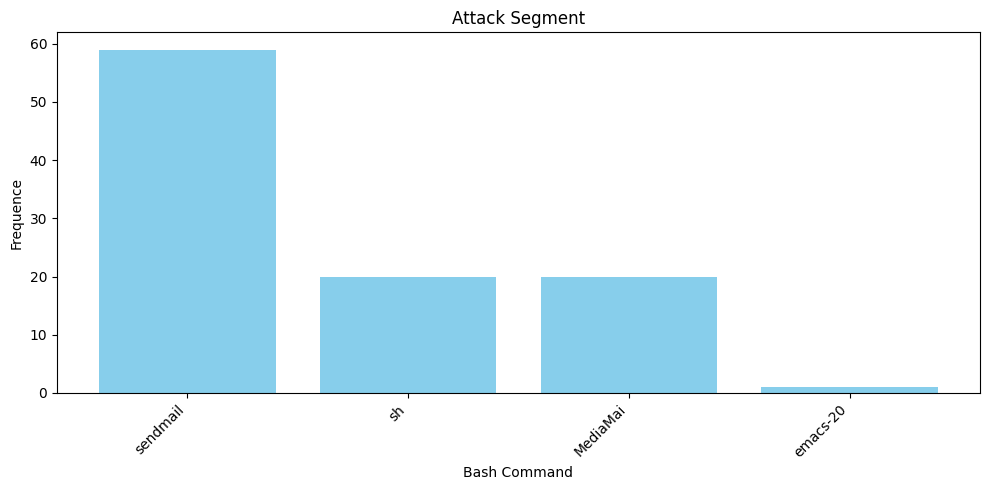

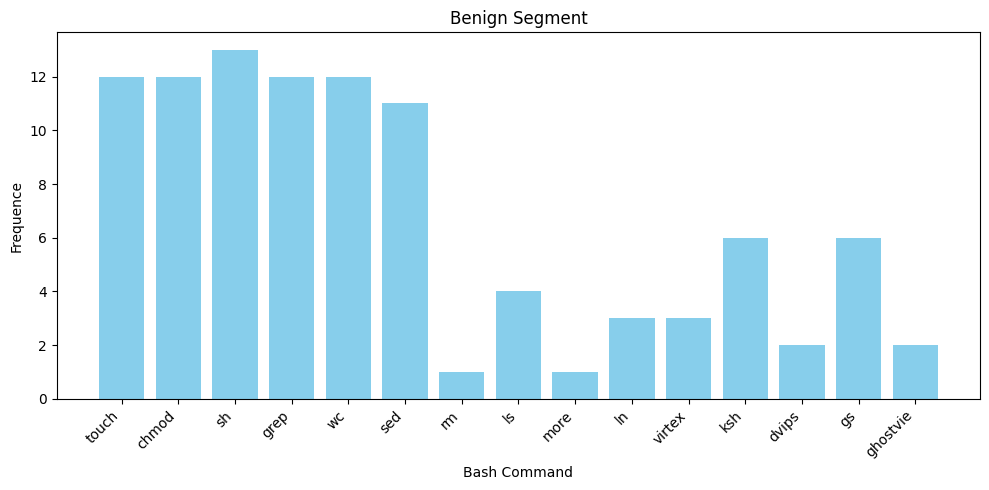

------------------------------------------------------------------------------------------


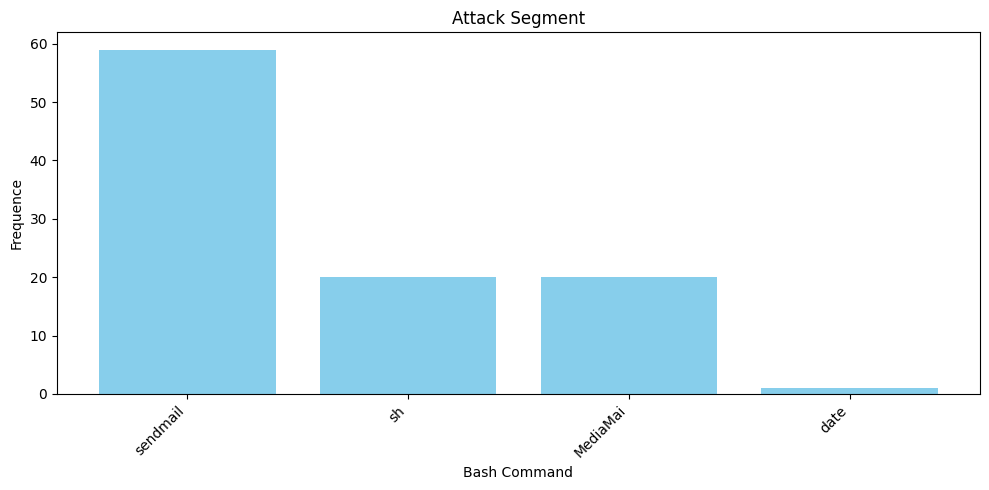

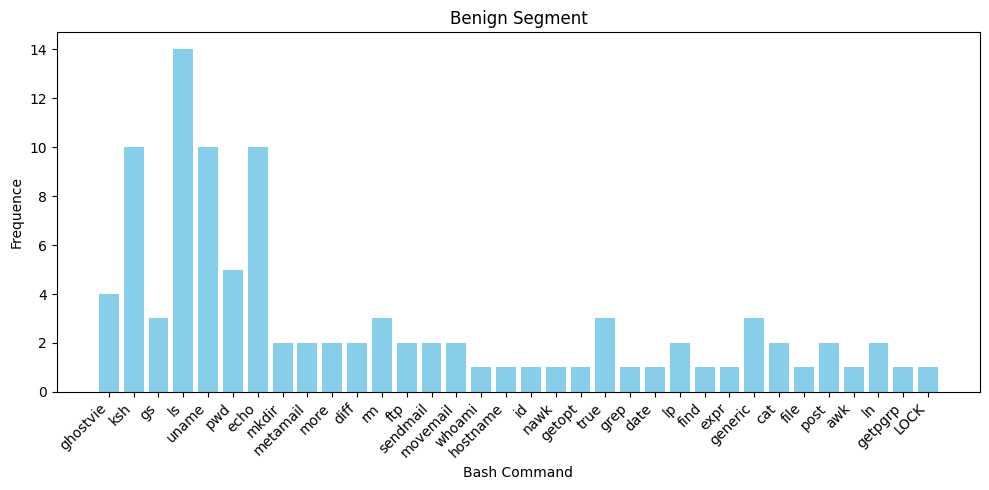

------------------------------------------------------------------------------------------


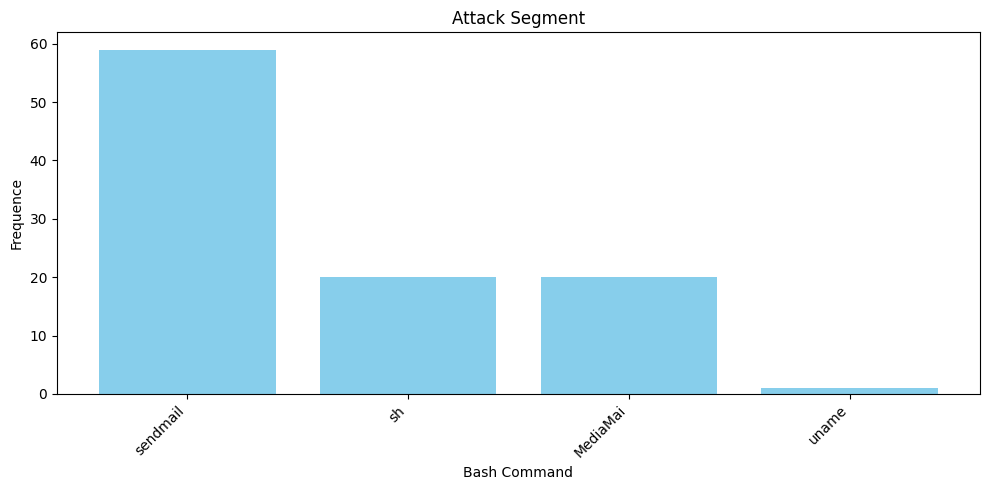

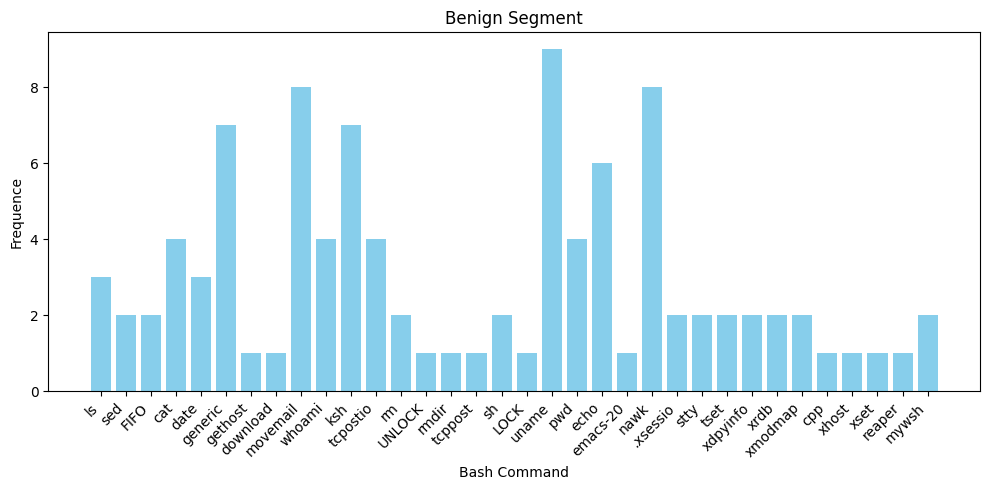

------------------------------------------------------------------------------------------


In [50]:
atack_sample: pd.DataFrame = validation_df[(validation_df['label'] == 1.0) & (validation_df['userId'] == 'User0')]
benign_sample: pd.DataFrame = validation_df[(validation_df['label'] == 0) & (validation_df['userId'] == 'User0')]

atack_sample = atack_sample['text'].apply(lambda s: Counter(s.split(' '))).to_list()
benign_sample = benign_sample['text'].apply(lambda s: Counter(s.split(' '))).to_list()

for i in range(3):
    dict_to_bar_plot(atack_sample[i], title='Attack Segment')
    dict_to_bar_plot(benign_sample[i], title='Benign Segment')
    print("---"*30)


## Validation

In [20]:
n_users: int = len(combined["userId"].unique())
models = {user: create_pipline() for user in range(n_users)}
models = train(train_df, models=models)
test(validation_df, models=models)

,preecision,recall,acc
0,0.974026,1.000000,0.976
1,0.906250,0.998889,0.906
2,0.969828,1.000000,0.972
3,0.923077,1.000000,0.925
4,0.965665,1.000000,0.968
5,0.935551,1.000000,0.938
6,0.953390,1.000000,0.956
7,0.927835,1.000000,0.930
8,0.932642,1.000000,0.935
9,0.930642,0.998889,0.932


## Prediction

In [21]:
# train model with all of the data
models = train(pd.concat([validation_df, train_df], axis=0), models=models)
pred_df = prediction(test_df, models=models)
# restrcture for label excel
final_df = pd.concat([train_df, validation_df, pred_df], axis=0)[
    ["userId", "segment", "label"]
].pivot(index="userId", columns="segment", values="label")
# save it 
final_df.to_csv("./challengeToFill.csv")
final_df.head(5)

segment,0-100,100-200,1000-1100,10000-10100,10100-10200,10200-10300,10300-10400,10400-10500,10500-10600,10600-10700,...,9000-9100,9100-9200,9200-9300,9300-9400,9400-9500,9500-9600,9600-9700,9700-9800,9800-9900,9900-10000
userId,,,,,,,,,,,,,,,,,,,,,
User0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User10,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
User11,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
User12,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
